# MLModel Fairness guide

## Table of Contents <a class="anchor" id="0"></a>
* [Introduction](#1) 
* [Fairness Analysis for Classification](#2)
    * [Prepare tabular data](#3)
    * [Load model architecture](#4)
    * [ML Model Training](#5)
    * [Estimate Fairness of Base Model](#6)
    * [Fairness report analysis for classification of base model](#7)
    * [Choosing a Metric](#9)   
    * [Bias mitigation ](#23)
    * [Estimate Model Fairness of Mitigated Model](#24)
* [Fairness Analysis for Regression](#4)
    * [Prepare tabular data](#3)
    * [Load model architecture](#2)
    * [ML Model Training](#3)
    * [Estimate Model Fairness of Base Model](#4)   
    * [Choosing a Metric](#9)   
    * [Bias mitigation ](#23)
    * [Estimate Model Fairness of Mitigated Model](#24)
* [Summary](#25)

## Introduction <a class="anchor" id="1"></a>

Bias in machine learning models can lead to unfair and discriminatory outcomes, especially when trained on historical data reflecting societal inequalities. This guide provides an overview of how to estimate and mitigate bias using [MLModel]() with backbones such as Random Forest, Gradient Boosting, LightGBM etc. and other available scikit-learn algorithms.

The `arcgis.learn` module includes [MLModel](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#mlmodel) classes to train machine learning and deep learning models on tabular data which can be any vector data in the form of a [feature layer](https://developers.arcgis.com/python/guide/working-with-feature-layers-and-features/) or [spatially enabled dataframe](https://developers.arcgis.com/python/guide/introduction-to-the-spatially-enabled-dataframe/).  The `MLModel` uses machine learning algorithms to train models and  allows you to use any [regression](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) or [classification](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) model from scikit-learn.


Here we will learn techniques to first identify bias in models with respect to features or variables which are prone to bias also called as sensitive features, and practical strategies to reduce unfairness following appropriate mitigation strategies, ensuring more equitable and unbiased models. By applying these methods, arcgis.learn api developers can create models for tabular data that make fairer decisions across diverse groups and minimize the risk of discrimination. Currenlty we support both classification and regression modeling for estimating fairness.

## Fairness Analysis for Classification<a class="anchor" id="2"></a>

Here we will discuss fairness estimation for classification.

## Prepare tabular data <a class="anchor" id="3"></a>

First we will start by creating the `TabularDataObject` using  `prepare_tabulardata()` method that can be fed into the `MLModel`, then initializing the model and then fitting the model. Refer to the [Machine learning and deep learning on tabular data](https://developers.arcgis.com/python/latest/guide/ml-and-dl-on-tabular-data/) documentation for further detail. One thing to be noted is that for estimating fairness, as of now we support only binary classification and regression modeling. So it is required that for classification  we choose a depedent variable with binary classes.

In [ ]:
data = prepare_tabulardata(input_features,
                            variable_predict, 
                            explanatory_variables=X,
                            explanatory_rasters=explanatory_rasters,
                            preprocessors=preprocessors)

## Load model architecture<a class="anchor" id="4"></a>  

The data prepared by the `prepare_tabulardata` method is ready to be passed to the `MLModel` method, along with the selected machine learning model for training. Here, for demonstration purpose, the `lightgbm.LGBMClassifier` model from scikit-learn is used, which is passed into the `MLModel` function, along with its parameters.

First, we import the `MLModel` framework from `arcgis.learn`. Then, we specify the model to be used from scikit-learn and define the necessary parameters as follows:

```python
from arcgis.learn import MLModel
model = MLModel(data, "lightgbm.LGBMClassifier", n_estimators=500, random_state=43)
```

In [ ]:
model = MLModel(data, "lightgbm.LGBMClassifier", n_estimators=500, random_state=43)

### ML Model Training<a class="anchor" id="5"></a>
Once the machine learning model is initialized with the data and the scikit-learn model parameters mentioned in the previous step, the `model.fit()` method is used for fitting the machine learning model. 

In [ ]:
model.fit()

### Estimate Fairness of Base Model <a class="anchor" id="6"></a>

Once the base model is trained the next critical step is to evaluate whether the trained model exhibits any bias.

This is the first step to measure model fairness use the provided function. Here we will use `fairness_score` function where the input paramters are sensitive feature

The fairness_score function assess fairness, takes the sensitive feature(s) as input parameters. This function helps quantify potential bias in the model’s predictions with respect to the specified sensitive attributes, enabling informed decisions about fairness mitigation strategies.

The Sensitive Feature Attribute parameteris defined as follows:

Sensitive Features—Biased or sensitive attributes in the dataset that can introduce unfairness in machine learning models. Examples of such attributes include race, gender, or socioeconomic status. By training the model while selecting these sensitive features, you can mitigate biases associated with them, resulting in a more unbiased model. The tool will assess and enhance fairness based on each attribute individually. This is also defined as the protected class column or feature name. Currently senstive features must be a categorical variable.

For example after training a model on predicitng salary data with Gender as one of the explanantory variables, we use the fairness score function with Gender as the sensitive feature to check if this is causing bais in the model. The following report is generated, which can be analysed to understand if the model has to be mitigated to remove this bias casused by this sensitive variable.

In [ ]:
model.fairness_score(sensitive_feature ='Gender',visualize=True)

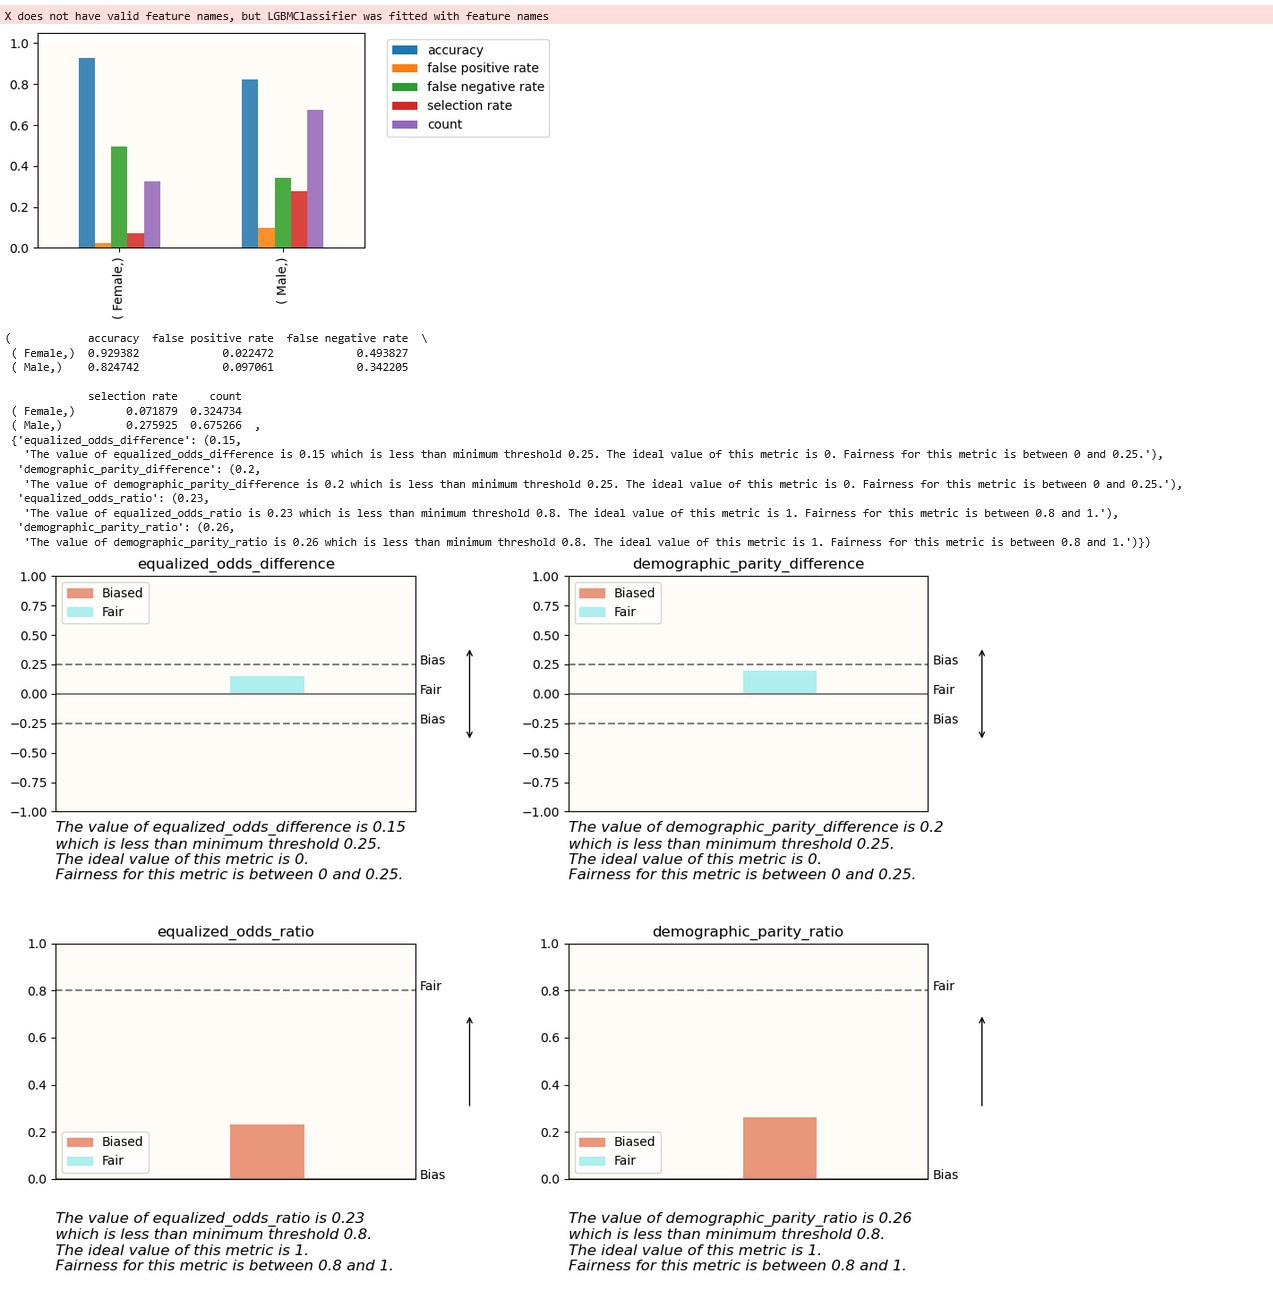

### Fairness report analysis for classification of base model<a class="anchor" id="7"></a>

This will generate a report along with charts to inform the user if the fitted model is bias or unbiased. Based on this if the model is biased, then we do not need to proceed with the next following step. The biasness is measured based on these four metrics as mentioned in the report. If all the four metrics are within the allowed range of the respective metrics then the model is considered to be unbias. However in most cases it is unusual to get all the four metrics as unbiased. Due to data quality usually there are inbuilt biasness in at least one of these metrics. In such a scenario we will proceed with bias mitigation. So let us analyse the generated report.

<h4>Metrics by Gender Group</h4>
<table style="border-collapse: collapse; width: 50%;">
  <thead>
    <tr>
      <th style="border: 1px solid black; border-right: none; padding: 6px; text-align: center;">Metric</th>
      <th style="border: 1px solid black; border-left: none; border-right: none; padding: 6px; text-align: center;">Female</th>
      <th style="border: 1px solid black; border-left: none; padding: 6px; text-align: center;">Male</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">Accuracy</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">92.9%</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">82.5%</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">False Positive Rate</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">2.2%</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">9.7%</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">False Negative Rate</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">49.4%</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">34.2%</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">Selection Rate</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">7.2%</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">27.6%</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">Count (Proportion)</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">32.5%</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">67.5%</td>
    </tr>
  </tbody>
</table>

 - Accuracy is higher for females (92.9%) than males (82.5%).

 - False Positive Rate (FPR) is much lower for females (2.2%) compared to males (9.7%), meaning males are more likely to be incorrectly classified as positive.

 - False Negative Rate (FNR) is higher for females (49.4%) than males (34.2%), indicating females are more often incorrectly classified as negative.

 - Selection Rate (proportion predicted positive) is significantly lower for females (7.2%) than males (27.6%), suggesting fewer females are selected or predicted positively.

<h4>Group Fairness Metrics</h4>
<table style="border-collapse: collapse; width: 80%;">
  <thead>
    <tr>
      <th style="border: 1px solid black; border-right: none; padding: 6px; text-align: center;">Metric</th>
      <th style="border: 1px solid black; border-left: none; border-right: none; padding: 6px; text-align: center;">Value</th>
      <th style="border: 1px solid black; border-left: none; padding: 6px; text-align: center;">Interpretation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">Equalized Odds Difference</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">0.15</td>
      <td style="border: 1px solid black; padding: 6px; text-align: left;">
        Below threshold (0.25), close to ideal (0). Indicates moderate fairness in balancing FPR and FNR.
      </td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">Demographic Parity Difference</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">0.20</td>
      <td style="border: 1px solid black; padding: 6px; text-align: left;">
        Below threshold (0.25), close to ideal (0). Suggests some disparity in positive prediction rates.
      </td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">Equalized Odds Ratio</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">0.23</td>
      <td style="border: 1px solid black; padding: 6px; text-align: left;">
        Below threshold (0.8), ideal is 1. Indicates disparity in error rates between groups.
      </td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">Demographic Parity Ratio</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">0.26</td>
      <td style="border: 1px solid black; padding: 6px; text-align: left;">
        Below threshold (0.8), ideal is 1. Shows imbalance in selection rates between groups.
      </td>
    </tr>
  </tbody>
</table>

Summary and Recommendation
 - The equalized odds difference and demographic parity difference values are within acceptable limits (<0.25), suggesting some fairness but not perfect.

 - The equalized odds ratio and demographic parity ratio are below their respective thresholds (0.8), indicating noticeable disparities in error rates and selection rates between genders.

 - The selection rate for females is much lower than for males, which could lead to unfair treatment or opportunity gaps.

While some fairness metrics are within acceptable ranges, the disparities in error rates and selection rates suggest the model exhibits bias against females. Therefore, it is advisable to proceed with bias mitigation for the appropriate metrics to improve fairness and reduce potential discrimination based on gender.

### Bias mitigation for Classification <a id='mitigation-dpr'></a> 

### Choosing a mitigation metric <a id='choosing-metric'></a>  

The first step for mitigation is to identify a sensitive feature in the data that is introducing the bias and specify an appropriate mitigation_type and mitigation_constraint which is the fairness metric to be optimized and adjusted to achieve demographic parity in positive outcomes (salary) between different gender groups. This will be different for clasification and regression. To do this, here we initiate the model using the sensitive variable as Gender, and since it is a classification model we will define  `mitigation_type` as `threshold_optimizer` and `mitigation_constraint` as `demographic_parity`.

For classification:
mitigation_type can be  - reweighing or threshold_optimizer or exponentiated_gradient
mitigation_constraint can be:    demographic_parity or equalized_odds

During mitigation for classification models we need to define the following fairness args paramters:

 - `sensitive_feature`
 - `mitigation_type` 
 - `mitigation_constraint`

Here the `sensitive_feature` would be Gender,  the feature in the data that is introducing the bias.

While for `mitigation_type`, there are three mitigation types to choose - reweighing, threshold_optimizer, and exponentiated_gradient.  

 - reweighing - A pre-processing technique that assigns weights to training samples to reduce bias before model training. It adjusts the importance of samples from different sensitive groups and outcome classes to balance the data distribution.

 - threshold_optimizer - A post-processing method that adjusts the decision thresholds for different sensitive groups to satisfy fairness constraints like equalized odds.

 - exponentiated_gradient - An in-processing approach that integrates fairness constraints directly into the model training by solving a constrained optimization problem using exponentiated gradient descent.

Here we will be using threshold_optimizer which is particularly effective for constraints like equalized odds because it explicitly balances false positive and false negative rates by group. It is also preferred to maintain model accuracy while improving fairness, and is comparitivley faster.

Next, There are two types of metrics that can be used for `mitigation_constraint`, and it’s important to select one that aligns with the fairness goals and the context of application: 

 - Equalized Odds
 - Demographic Parity


Equalized Odds: Equalized odds requires that the model’s false positive rates and true positive rates be similar across sensitive groups (e.g., gender). This metric ensures that the model performs equally well for all groups, balancing both types of errors and preventing one group from being unfairly disadvantaged by higher error rates. It is stricter and more comprehensive than demographic parity, which only focuses on equal selection rates without considering error rates.

In the above fairness report, disparities exist in false positive and false negative rates between females and males. Using equalized odds as the mitigation target directly addresses these disparities by aiming to equalize these error rates across groups.

Demographic Parity: Demographic parity ensures that the selection rate (positive prediction rate) is similar across groups. It is simpler but can lead to unintended consequences if error rates remain unequal.

If the primary concern is equalizing overall positive outcomes regardless of true labels, demographic parity might be appropriate. However, since the report shows imbalances in error rates, equalized odds is generally preferred.

Hence in the current context Equalized Odds is recommended for bias mitigation to ensure fairness in both false positives and false negatives, leading to balanced model performance across groups. Demographic Parity to be used if the focus is on equalizing positive prediction rates, but be aware it may overlook differences in error rates.

Following this diagnosis, we will now attempt to mitigate demographic parity bias caused by gender. First we define the fairness_args as a dictionary using these as keys and arguments as follows: 

In [ ]:
# Example fairness argument for classification
fairness_args = {'sensitive_feature': 'Gender',
                 'mitigation_type': "threshold_optimizer",
                 'mitigation_constraint':'demographic_parity' 
                                                        }

After defining creating fairness_args Then we will initialize the Mlmodel with the selcted fairness metrics we pass it as the fairness_args parameter while initiating the model for mitigation.  

In [ ]:
model = MLModel(data, "lightgbm.LGBMClassifier", fairness_args=fairness_args, n_estimators=500, random_state=43)

Now we will proceed to training the model. This is done by calling the fit method as shown below. 

In [ ]:
model.fit()

### Estimate Fairness of Mitigated Model <a class="anchor" id="10"></a>

Once the model is trained, it will have mitigated the bias. This can be verified by running the `fairness_score()` function again to evaluate whether the mitigated model has resolved the esixting bias in the model’s predictions with respect to the same specified sensitive feature or attribute of Gender. 

The model report below shows that now three indicator out of four has turned green. This suggests that bias mitigation has been successfully achieved. 

In [ ]:
model.fairness_score(sensitive_feature ='Gender',visualize=True)

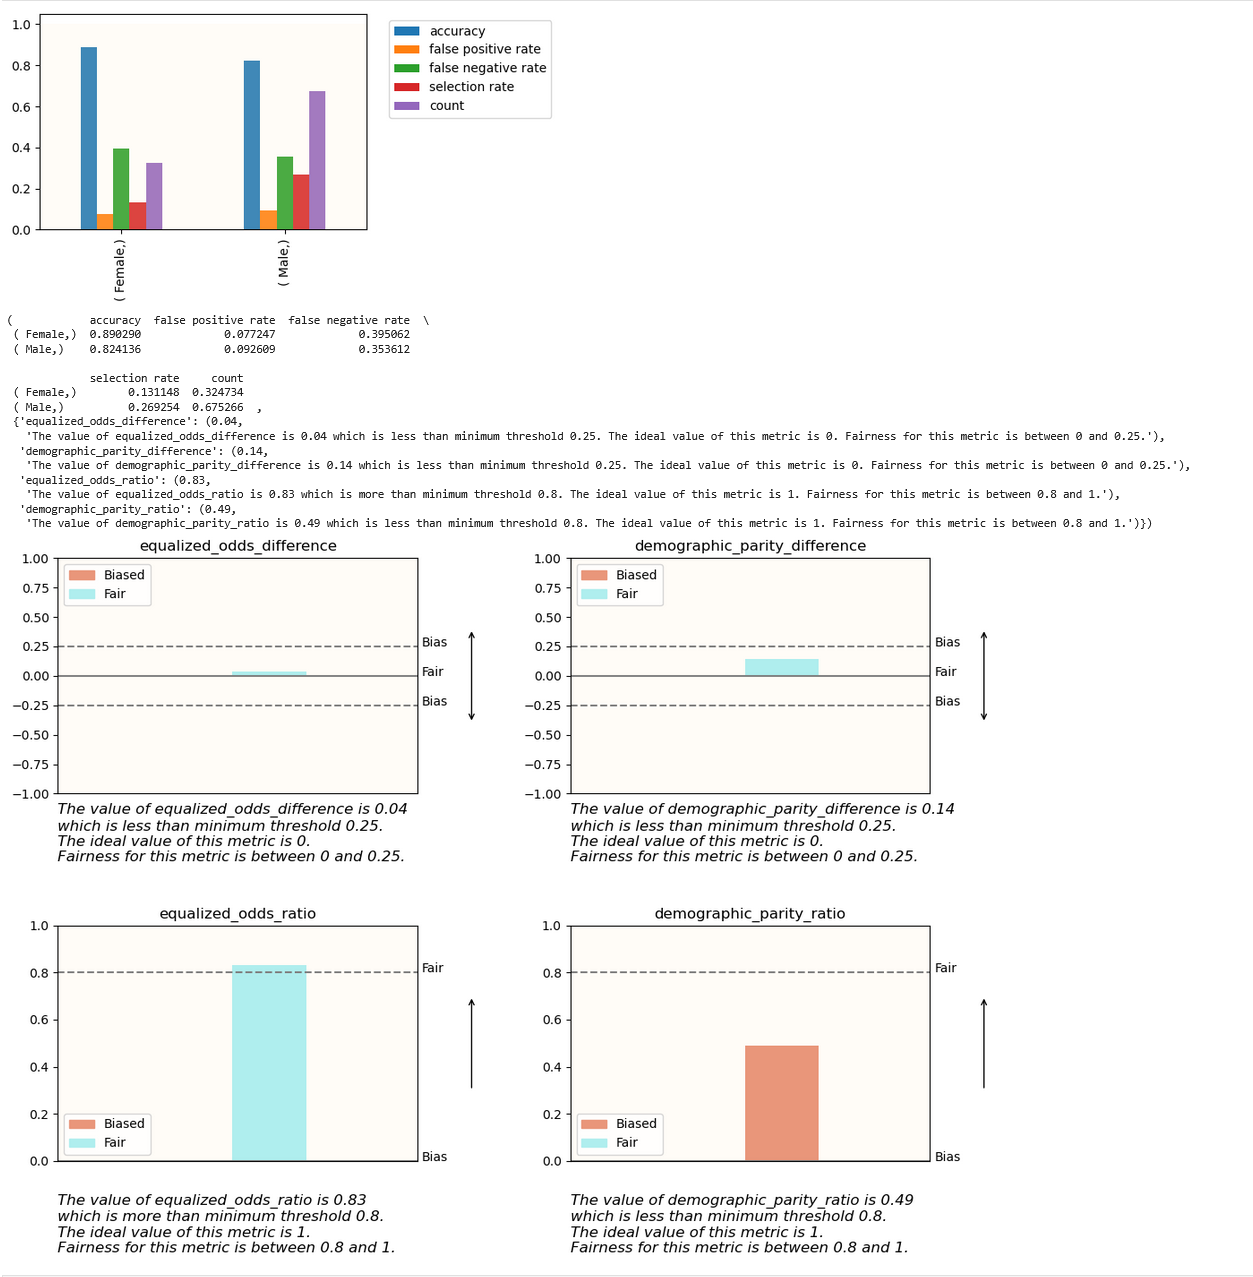

Let's analyze the fairness report after mitigation, compare it with the previous report, and summarize the key changes in a table.

### Interpretation of Fairness Report After Mitigation for Salary Classifier by Gender

<h4>Metrics by Gender Group</h4>
<table style="border-collapse: collapse; width: 50%;">
  <thead>
    <tr>
      <th style="border: 1px solid black; border-right: none; padding: 6px; text-align: center;">Metric</th>
      <th style="border: 1px solid black; border-left: none; border-right: none; padding: 6px; text-align: center;">Female</th>
      <th style="border: 1px solid black; border-left: none; padding: 6px; text-align: center;">Male</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">Accuracy</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">89.0%</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">82.4%</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">False Positive Rate</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">7.7%</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">9.3%</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">False Negative Rate</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">39.5%</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">35.4%</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">Selection Rate</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">13.1%</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">26.9%</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">Count (Proportion)</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">32.5%</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">67.5%</td>
    </tr>
  </tbody>
</table>

 - Accuracy: Female accuracy decreased slightly from 92.9% to 89.0%, Male accuracy remains similar (82.5% to 82.4%).

 - False Positive Rate (FPR): Female FPR increased from 2.2% to 7.7%, Male FPR decreased slightly from 9.7% to 9.3%. The gap between groups narrowed.

 - False Negative Rate (FNR): Female FNR decreased significantly from 49.4% to 39.5%, Male FNR slightly increased from 34.2% to 35.4%. The difference between groups reduced.

 - Selection Rate: Female selection rate increased from 7.2% to 13.1%, Male selection rate decreased from 27.6% to 26.9%. The disparity in selection rates reduced but still exists.

<h4>Group Fairness Metrics</h4>
<table style="border-collapse: collapse; width: 80%;">
  <thead>
    <tr>
      <th style="border: 1px solid black; border-right: none; padding: 6px; text-align: center;">Metric</th>
      <th style="border: 1px solid black; border-left: none; border-right: none; padding: 6px; text-align: center;">Value</th>
      <th style="border: 1px solid black; border-left: none; padding: 6px; text-align: center;">Interpretation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">Equalized Odds Difference</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">0.04</td>
      <td style="border: 1px solid black; padding: 6px; text-align: left;">
        Well below threshold (0.25), very close to ideal (0). Indicates strong fairness in balancing FPR and FNR.
      </td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">Demographic Parity Difference</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">0.14</td>
      <td style="border: 1px solid black; padding: 6px; text-align: left;">
        Below threshold (0.25), improved fairness in positive prediction rates compared to before.
      </td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">Equalized Odds Ratio</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">0.83</td>
      <td style="border: 1px solid black; padding: 6px; text-align: left;">
        Above threshold (0.8), close to ideal (1). Indicates good parity in error rates between groups.
      </td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">Demographic Parity Ratio</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">0.49</td>
      <td style="border: 1px solid black; padding: 6px; text-align: left;">
        Still below threshold (0.8), but improved compared to before. Shows reduced imbalance in selection rates.
      </td>
    </tr>
  </tbody>
</table>

Comparing the above before and after mitigation reports we can summarize:

 - Fairness improved significantly after mitigation, especially in balancing error rates (equalized odds difference dropped from 0.15 to 0.04).

 - Selection rate disparities reduced, but demographic parity ratio (0.49) still indicates some imbalance.

 - Some trade-offs observed: Female false positive rate increased and accuracy slightly decreased for females, reflecting the typical accuracy-fairness trade-off.

 - Overall, the mitigation strategy successfully improved fairness metrics related to equalized odds, which was the targeted constraint.

Fianlly we can now use this mitigated model to predict and validate to ensure that the performance remains consistent with previous evaluations, which should be approximately the same as before.

## Fairness Analysis for Regression

For regression models, we follow a similar workflow. First, the data is prepared using the `prepare_tabulardata` method, where the target variable `variable_predict` is continuous. For demonstration purposes, we use the `RandomForestRegressor` model from scikit-learn via the `MLModel` function, specifying its parameters accordingly.

```python
from arcgis.learn import MLModel
model = MLModel(data, 'sklearn.ensemble.RandomForestRegressor', n_estimators=500, random_state=43)
```

In [ ]:
data = prepare_tabulardata(train,
                           'annual_salary_$',
                           explanatory_variables=X,              
                           )

In [ ]:
model = MLModel(data, 'sklearn.ensemble.RandomForestRegressor', n_estimators=500, random_state=43)
model.fit()

### Estimate Model Fairness of Base Model <a class="anchor" id="10"></a>

After training the model to predict salary using `Gender` as one of the explanatory variables, we evaluate its fairness by applying the fairness scoring function with `Gender` as the sensitive feature. The resulting report provides metrics such as fairness metric difference and ratio, which help assess whether the model exhibits bias related to Gender.

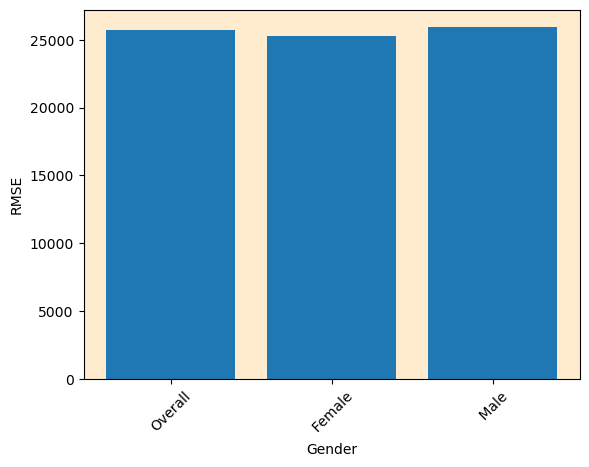

,fairness_metric_name,fairness_metric_diff,fairness_metric_ratio,is_ratio_fair,is_diff_fair
Gender,RMSE,-675.4206,1.0268,True,True


In [12]:
model.fairness_score(sensitive_feature ='Gender',visualize=True)

### Fairness Metrics Analysis
By analyzing these indices, we can determine if the model requires mitigation to reduce or eliminate bias introduced by this sensitive variable. The analysis is summarized as follows:

- **fairness_metric_diff = -675.4206**  
  This indicates a difference of approximately **675.42** in RMSE between male and female gender groups.  
  The negative sign shows the direction of the difference, but the magnitude is the key factor.  
  A difference of this size suggests some disparity in model error between genders.

- **fairness_metric_ratio = 1.0268**  
  The RMSE for one gender group is about **2.68% higher** than the other.  
  This ratio is fairly close to 1, indicating a relatively small disparity.

- **is_ratio_fair = True** and **is_diff_fair = True**  
  Both boolean flags indicate that the difference and ratio are within acceptable fairness thresholds defined by your criteria.


Although there is a noticeable RMSE difference (675.42), the model's performance disparity between genders is considered fair according to the thresholds used. The ratio close to 1 (1.0268) supports that the model predictions are fairly balanced between gender groups.

### Bias mitigation for Regression

We can see that expcept the large RMSE difference, the report before mitigation suggests that the base model is already quite fair with respect to gender. Though the fairness flags being True confirms that the model meets the fairness standards for gender, however the large RMSE difference seems to be an issue. Let us see if applying suitable mitigation strategy can improve this.  First we will define the fairness arguments as follows:

For regression:
mitigation_type can be - grid_search or exponentiated_gradient
mitigation_constraint: 'ZeroOneLoss' or 'SquareLoss'

In [13]:
# Example fairness argument for regression 
fairness_args = {'sensitive_feature': 'Gender',
                 'mitigation_type': "grid_search",
                 'mitigation_constraint':'ZeroOneLoss'
                }

Then using this arguments we initiate the regression model with the same algorithm as used for the base model, and fit the model.

In [14]:
model = MLModel(data, 'sklearn.ensemble.RandomForestRegressor', fairness_args=fairness_args, n_estimators=500, random_state=43)

Initializing for Regression 


In [15]:
model.fit()

Fitting with grid_search


Finally we check the new fairness score of the mitigated model using the `fairness_score` function as follws:

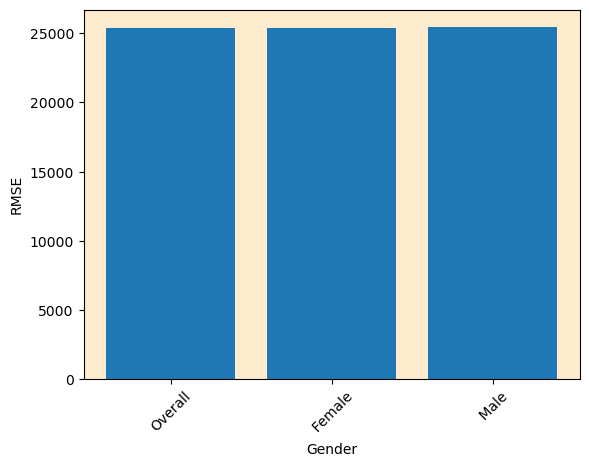

,fairness_metric_name,fairness_metric_diff,fairness_metric_ratio,is_ratio_fair,is_diff_fair
Gender,RMSE,-80.3214,1.0032,True,True


In [16]:
model.fairness_score(sensitive_feature ='Gender',visualize=True)

### Fairness Metrics Analysis for Mitigated Model

Now, let us analyze the indices of the mitigated model to determine whether the bias related to this sensitive variable has been reduced or eliminated. The analysis is summarized as follows:

- **fairness_metric_diff = -80.3214**  
  This value represents the difference in RMSE (Root Mean Squared Error) between gender groups.  
  The negative sign indicates the direction of the difference, but the magnitude (~80.32) is relatively small, suggesting a minor disparity in prediction error between genders.

- **fairness_metric_ratio = 1.0032**  
  This ratio means that the RMSE for one gender group is only about **0.32% higher** than the other group, which is very close to perfect parity (ratio = 1).

- **is_ratio_fair = True** and **is_diff_fair = True**  
  Both boolean indicators confirm that the difference and ratio are within acceptable fairness thresholds.  
  This implies the model treats gender groups fairly according to the defined criteria.


The model shows very little disparity in error rates between genders, as reflected by the small RMSE difference and ratio close to 1. The fairness flags being True confirm that the model meets the fairness standards for gender. It suggests that the base model was already quite fair with respect to gender.

<h4>Summary Comparison (Gender Before vs After Mitigation)</h4>
<table style="border-collapse: collapse; width: 50%;">
  <thead>
    <tr>
      <th style="border: 1px solid black; border-right: none; padding: 6px; text-align: center;">Metric</th>
      <th style="border: 1px solid black; border-left: none; border-right: none; padding: 6px; text-align: center;">Before Mitigation</th>
      <th style="border: 1px solid black; border-left: none; padding: 6px; text-align: center;">After Mitigation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">fairness_metric_diff</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">-675.4206</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">-80.3214</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">fairness_metric_ratio</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">1.0268</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">1.0032</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">is_ratio_fair</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">True</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">True</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">is_diff_fair</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">True</td>
      <td style="border: 1px solid black; padding: 6px; text-align: center;">True</td>
    </tr>
  </tbody>
</table>

Finally comparing the before and after mitigation report for the regression modelign we can summarize that:

 - The difference in RMSE decreased substantially after mitigation (from ~675 to ~80).
 - The ratio moved closer to perfect parity (from 1.0268 to 1.0032).

#### Summary of Fairness Evaluation

Both models meet the fairness criteria, but mitigation clearly improved fairness by reducing disparity. The base model before mitigation was fair but exhibited moderate disparity in error rates between genders. Mitigation efforts successfully reduced this disparity, resulting in a more balanced and fair model. Monitoring both difference and ratio metrics is essential to ensure fairness across sensitive groups.